### RNN with Attention (Possible solution)

In [1]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Step 1: Prepare the Data
df = pd.read_csv('T1.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='mixed')
df.set_index('Date/Time', inplace=True)

df_rel = df.copy().drop('Wind Direction (°)', axis=1)
data = df_rel.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape

(50530, 3)

In [5]:
# Step 2: Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i,0])
        y.append(data[i,0])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = np.array(y)
    return X, y

seq_size = 24
X, y = create_sequences(scaled_data, seq_size)

In [6]:
# Step 3: Split the data
split = int(0.8 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Print the shapes of the training and test sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (40404, 24, 1)
y_train shape: (40404,)
X_test shape: (10102, 24, 1)
y_test shape: (10102,)


In [7]:
# Step 4: Define a Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [8]:
# Step 5: Build the RNN Model with Attention
# Define the input layer with shape (seq_length, 1)
input_seq = Input(shape=(seq_size, 1))
# Add an LSTM layer that outputs the full sequence
lstm_out = LSTM(50, return_sequences=True)(input_seq)
# Apply the custom attention layer
context_vector, attention_weights = AttentionLayer()(lstm_out)
# Add a final Dense layer for regression (linear activation)
output = Dense(1, activation='linear')(context_vector)
# Create the model
model = Model(inputs=input_seq, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │         2,550 │
│ (AttentionLayer)                │ 24, 50)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 6: Compile and Train the Model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 2/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 3/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 4/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 5/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 6/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 7/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 8/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 9/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 10/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 11/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 12/50
1263/1263 ━━━━━━━━

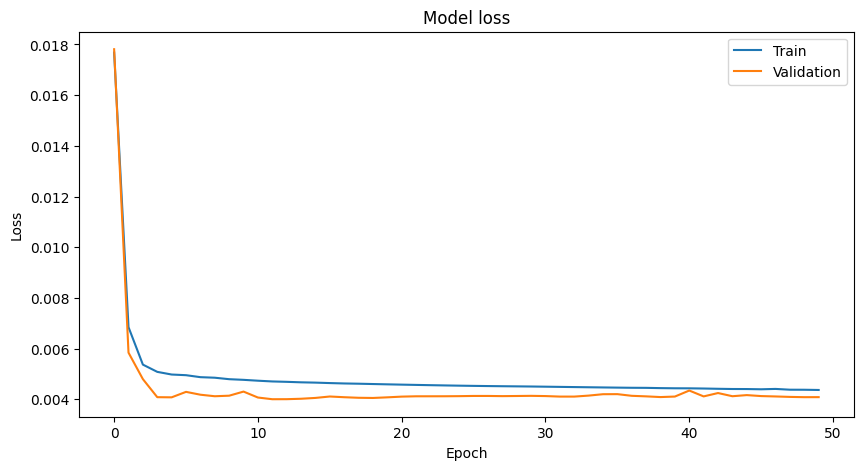

In [13]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MSE: 53558.731686356055
Test RMSE: 231.4275949111429
Test R2: 0.9702608133202835


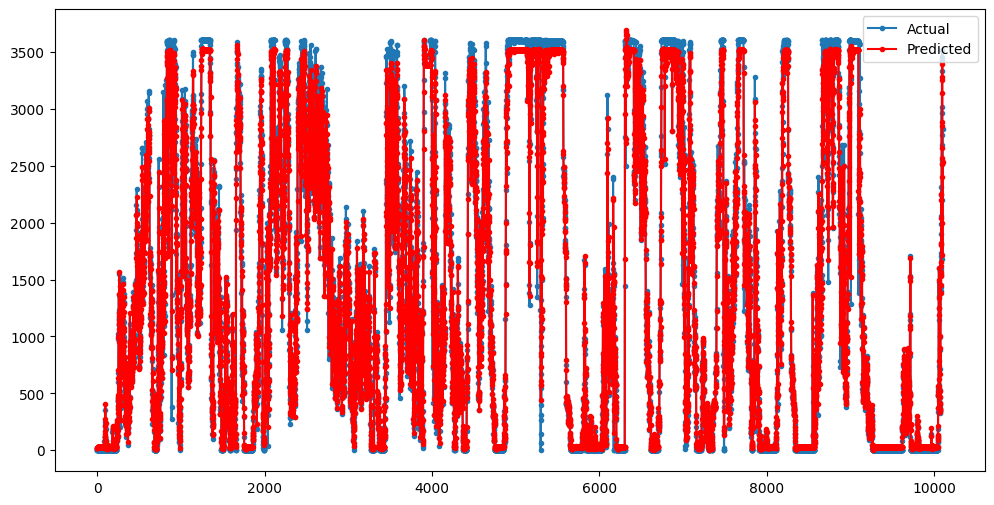

In [14]:
# Step 7: Evaluate the Model
y_pred = model.predict(X_test)
y_pred_new = y_pred.reshape(-1)
# Inverse transform the predictions and actual values
y_pred_to_inv = np.zeros((10102,3))
#set the first column to y_pred
y_pred_to_inv[:,0] = y_pred_new
y_test_to_inv = np.zeros((10102,3))
#set the first column to y_test
y_test_to_inv[:,0] = y_test

y_pred_inv = scaler.inverse_transform(y_pred_to_inv) 
y_test_inv = scaler.inverse_transform(y_test_to_inv)

#extract the first column from y_pred_inv and y_test_inv
y_pred_inv = y_pred_inv[:,0]
y_test_inv = y_test_inv[:,0]
# Calculate the MSE
mse = ((y_pred_inv - y_test_inv)**2).mean(axis=0)
print(f'Test MSE: {mse}')
# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse}')
# Calculate R2
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'Test R2: {r2}')
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, 'r', marker='.', label="Predicted")
plt.legend()
plt.show()